In [20]:
# Core
from __future__ import annotations
from pathlib import Path

# Data
import polars as pl
import numpy as np
import pandas as pd

# Plotting (matplotlib only; clean + publication-ish defaults)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Optional: nicer text rendering in many environments
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "figure.dpi": 120,
    "savefig.dpi": 200,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlepad": 12,
    "axes.labelpad": 8,
    "legend.frameon": False,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

pl.Config.set_tbl_rows(-1)

polars.config.Config

## Setup and Filters Used for this Backtest

* Call Price > 0 & Call Price < 10
* Put Price > 0 & Put Price < 10
* abs(Call Delta + Put Delta) < 0.2
* Call Vega > 0.001 & Call Vega < 0.2
* Put Vega > 0.001 & Put Vega < 0.2
* Call IV > 0.1 & Call IV < 2
* Put IV > 0.1 & Put IV < 2
* Vega per trade = 100
* Universe every names in SP500 where the rolling average volume over 20days was greater than 10000 in its history

## Details on strategy
### Long side
* Find expiry the closest to but after earnings. 
* Buy Straddle nearest ATM 10 business days (or closest to) at the before earnings.
* Sell at the close right before earning. If AMC then sell the same day of earning, if BMO sell the day before.

### Short side 
* Find expiry the closest to but after earnings. 
* Sell Straddle right before earning. If AMC then sell the same day of earning, if BMO sell the day before.
* Buy back the position at the close of next day. (Buying at open might be better but didn't have or want to deal with open data side of things.) 

In [33]:
def plot_cumulative_pnl(
    dfs: dict[str, pl.DataFrame],
    date_col: str = "tradingDate",
    pnl_col: str = "daily_pnl",
    title: str = "Cumulative PnL (Long vs Short)",
):
    """
    dfs: dict like {"Long": df_long, "Short": df_short, "Both": df_both(optional)}
    Each df must contain date_col and pnl_col.
    """

    series = {}

    for name, df in dfs.items():
        if df is None or df.is_empty():
            continue

        if date_col not in df.columns or pnl_col not in df.columns:
            raise ValueError(f"{name}: missing '{date_col}' or '{pnl_col}'")

        pdf = (
            df.select([date_col, pnl_col])
            .sort(date_col)
            .to_pandas()
        )
        pdf[date_col] = pd.to_datetime(pdf[date_col])
        pdf = pdf.dropna(subset=[pnl_col])

        pdf["cum_pnl"] = pdf[pnl_col].cumsum()
        series[name] = pdf

    if not series:
        raise ValueError("No valid time series to plot.")

    fig, ax = plt.subplots(figsize=(14, 6))

    for name, pdf in series.items():
        ax.plot(pdf[date_col], pdf["cum_pnl"], label=name)

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative PnL")
    ax.axhline(0.0, linewidth=1)
    ax.legend()

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())
    )

    plt.show()


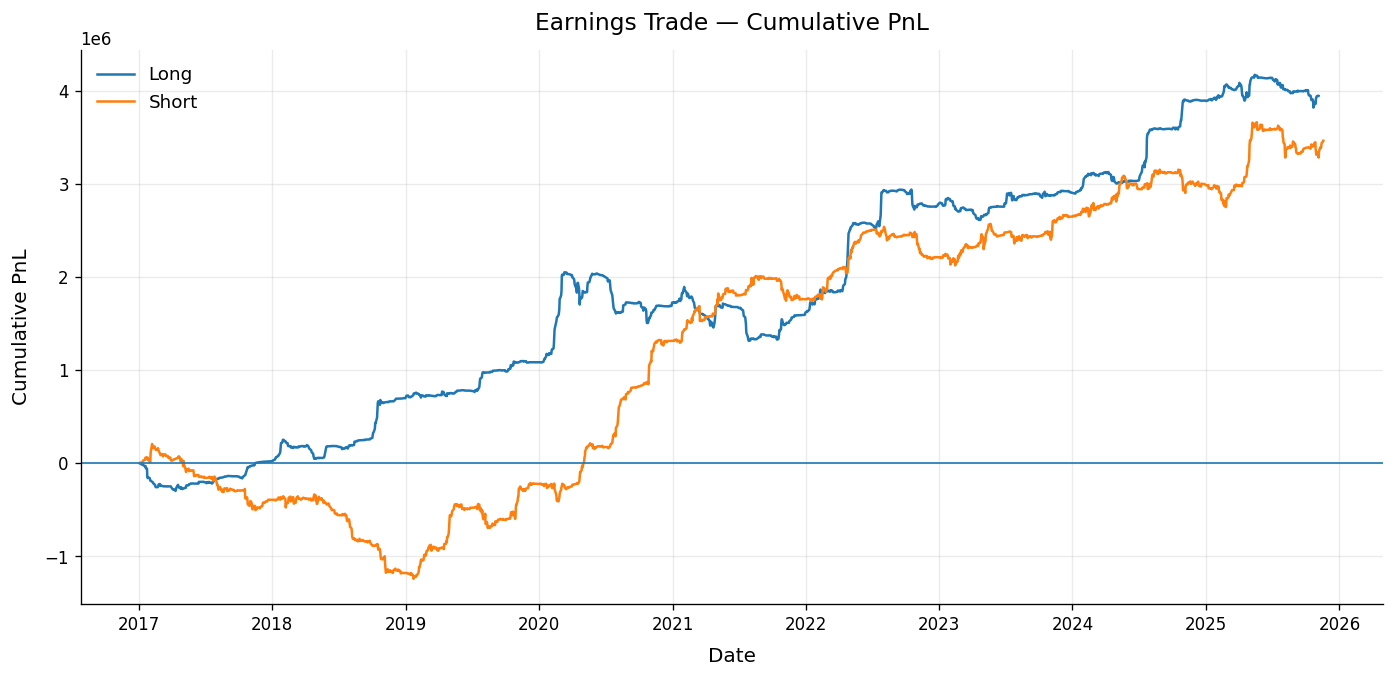

In [25]:
# If your daily dataframes include both Long and Short already, pass them directly.
plot_cumulative_pnl(
    {"Long": df_long, "Short": df_short},
    title="Earnings Trade — Cumulative PnL"
)


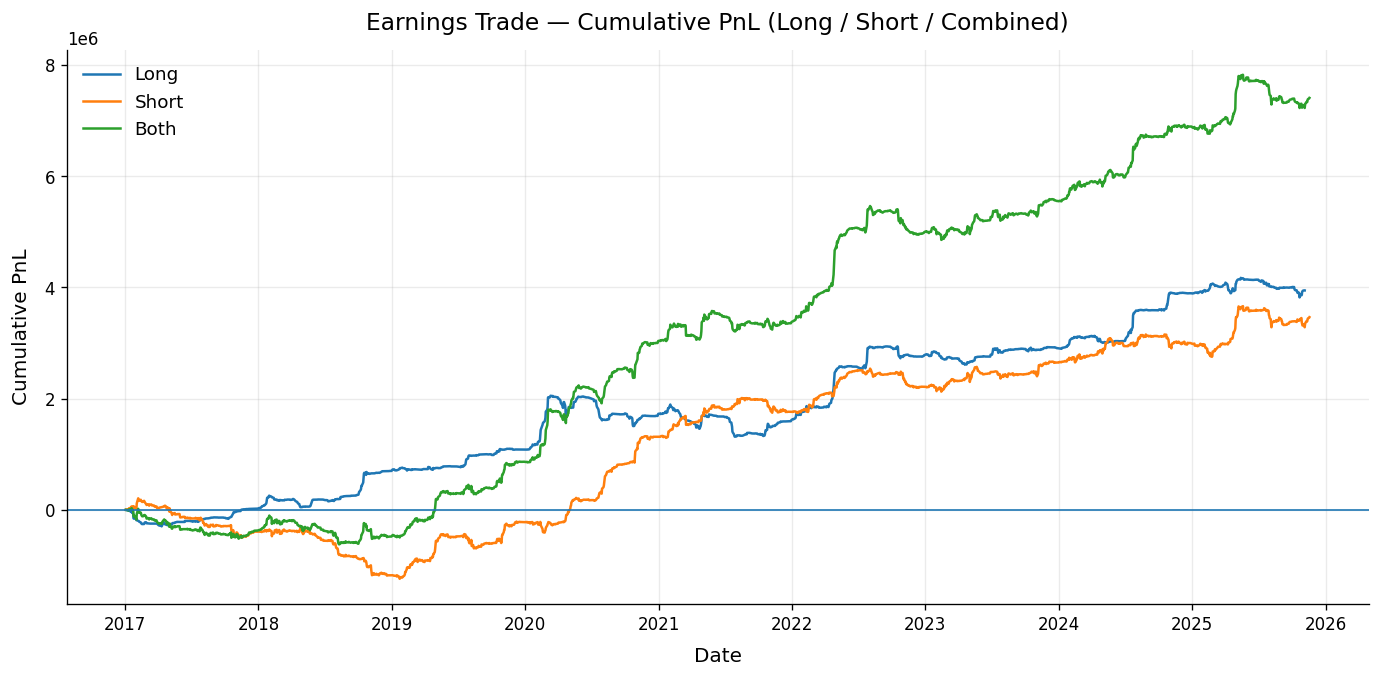

In [26]:
df_both = (
    pl.concat([df_long.select(["tradingDate","daily_pnl"]), df_short.select(["tradingDate","daily_pnl"])])
    .group_by("tradingDate")
    .agg(pl.col("daily_pnl").sum().alias("daily_pnl"))
    .sort("tradingDate")
)

plot_cumulative_pnl(
    {"Long": df_long, "Short": df_short, "Both": df_both},
    title="Earnings Trade — Cumulative PnL (Long / Short / Combined)"
)


In [2]:
LONG_TS_PATH  = Path("/htaa/llanteigne/packages/prd3/onepipeline/onepipeline/laurent_playground/tradedesk_research/earning_trade/data/long.parquet")
SHORT_TS_PATH  = Path("/htaa/llanteigne/packages/prd3/onepipeline/onepipeline/laurent_playground/tradedesk_research/earning_trade/data/short.parquet")

In [4]:
def _load_timeseries(path: Path) -> pl.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    df = pl.read_parquet(path)

    # Normalize expected columns
    # tradingDate: ensure Date type
    if "tradingDate" not in df.columns:
        raise ValueError(f"{strategy_name}: missing required column 'tradingDate' in {path}")

    # If tradingDate is Datetime, cast to Date for quarter groupings
    if df.schema["tradingDate"] == pl.Datetime:
        df = df.with_columns(pl.col("tradingDate").cast(pl.Date))
    elif df.schema["tradingDate"] == pl.Utf8:
        df = df.with_columns(pl.col("tradingDate").str.to_date().alias("tradingDate"))

    # PnL column
    if "daily_pnl" not in df.columns:
        # If you used a different name, change here
        raise ValueError(f"{strategy_name}: missing required column 'daily_pnl' in {path}")

    # VIX column (you said you've added it)
    if "VIX" not in df.columns:
        raise ValueError(f"{strategy_name}: missing required column 'VIX' in {path}")


    # Add quarter label (e.g., 2025Q4)
    df = df.with_columns(
        (pl.col("tradingDate").dt.year().cast(pl.Utf8) + pl.lit("Q") + pl.col("tradingDate").dt.quarter().cast(pl.Utf8))
        .alias("quarter")
    )

    return df

df_long  = _load_timeseries(LONG_TS_PATH)
df_short = _load_timeseries(SHORT_TS_PATH)

df_long.head(), df_short.head()


(shape: (5, 5)
 ┌─────────────┬──────────┬──────────────┬───────┬─────────┐
 │ tradingDate ┆ pos_sign ┆ daily_pnl    ┆ VIX   ┆ quarter │
 │ ---         ┆ ---      ┆ ---          ┆ ---   ┆ ---     │
 │ date        ┆ str      ┆ f32          ┆ f32   ┆ str     │
 ╞═════════════╪══════════╪══════════════╪═══════╪═════════╡
 │ 2017-01-03  ┆ Long     ┆ -3338.294434 ┆ 12.99 ┆ 2017Q1  │
 │ 2017-01-04  ┆ Long     ┆ -2730.555664 ┆ 11.85 ┆ 2017Q1  │
 │ 2017-01-05  ┆ Long     ┆ -1270.486084 ┆ 11.67 ┆ 2017Q1  │
 │ 2017-01-06  ┆ Long     ┆ -1636.756592 ┆ 11.4  ┆ 2017Q1  │
 │ 2017-01-09  ┆ Long     ┆ -5349.150879 ┆ 11.58 ┆ 2017Q1  │
 └─────────────┴──────────┴──────────────┴───────┴─────────┘,
 shape: (5, 5)
 ┌─────────────┬──────────┬──────────────┬───────┬─────────┐
 │ tradingDate ┆ pos_sign ┆ daily_pnl    ┆ VIX   ┆ quarter │
 │ ---         ┆ ---      ┆ ---          ┆ ---   ┆ ---     │
 │ date        ┆ str      ┆ f32          ┆ f32   ┆ str     │
 ╞═════════════╪══════════╪══════════════╪═══════╪════

In [12]:
def plot_quarterly_histograms(
    df: pl.DataFrame,
    pnl_col: str = "daily_pnl",
    quarter_col: str = "quarter",
    title_prefix: str = "",
    bins: int = 60,
):
    pdf = df.select(["tradingDate", quarter_col, pnl_col]).to_pandas()

    quarters = sorted(pdf[quarter_col].dropna().unique())
    if not quarters:
        raise ValueError("No quarters found to plot.")

    n = len(quarters)
    ncols = 2
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows), constrained_layout=True)
    axes = np.array(axes).reshape(-1)

    pnl_vals = pdf[pnl_col].replace([np.inf, -np.inf], np.nan).dropna()
    if len(pnl_vals) == 0:
        raise ValueError("No valid PnL values to plot.")

    # Keep consistent x-range across quarters for this strategy
    lo, hi = np.quantile(pnl_vals, [0.01, 0.99])

    for i, q in enumerate(quarters):
        ax = axes[i]
        qvals = pdf.loc[pdf[quarter_col] == q, pnl_col].replace([np.inf, -np.inf], np.nan).dropna()

        q_sum = float(qvals.sum()) if len(qvals) else 0.0
        q_mean = float(qvals.mean()) if len(qvals) else 0.0

        ax.hist(qvals, bins=bins, range=(lo, hi))
        ax.axvline(q_mean, linestyle="--")

        ax.set_title(f"{title_prefix}{q} (n={len(qvals)}) | Sum PnL={q_sum:,.0f}")
        ax.set_xlabel("Daily PnL")
        ax.set_ylabel("Frequency")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"{title_prefix}Quarterly Daily PnL Histograms", y=1.02, fontsize=16)
    plt.show()


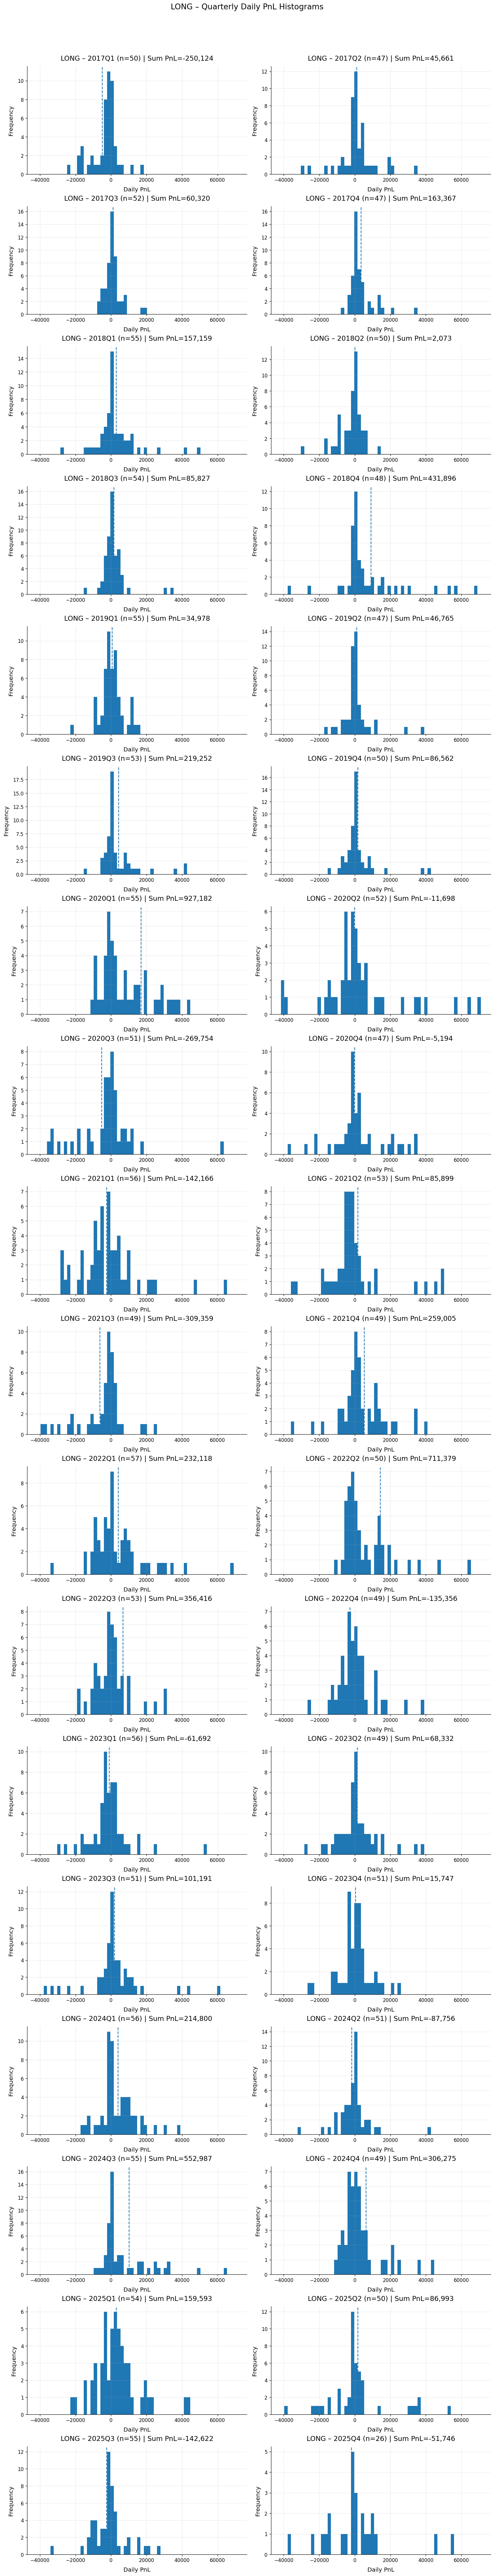

In [13]:
plot_quarterly_histograms(df_long,  title_prefix="LONG – ")

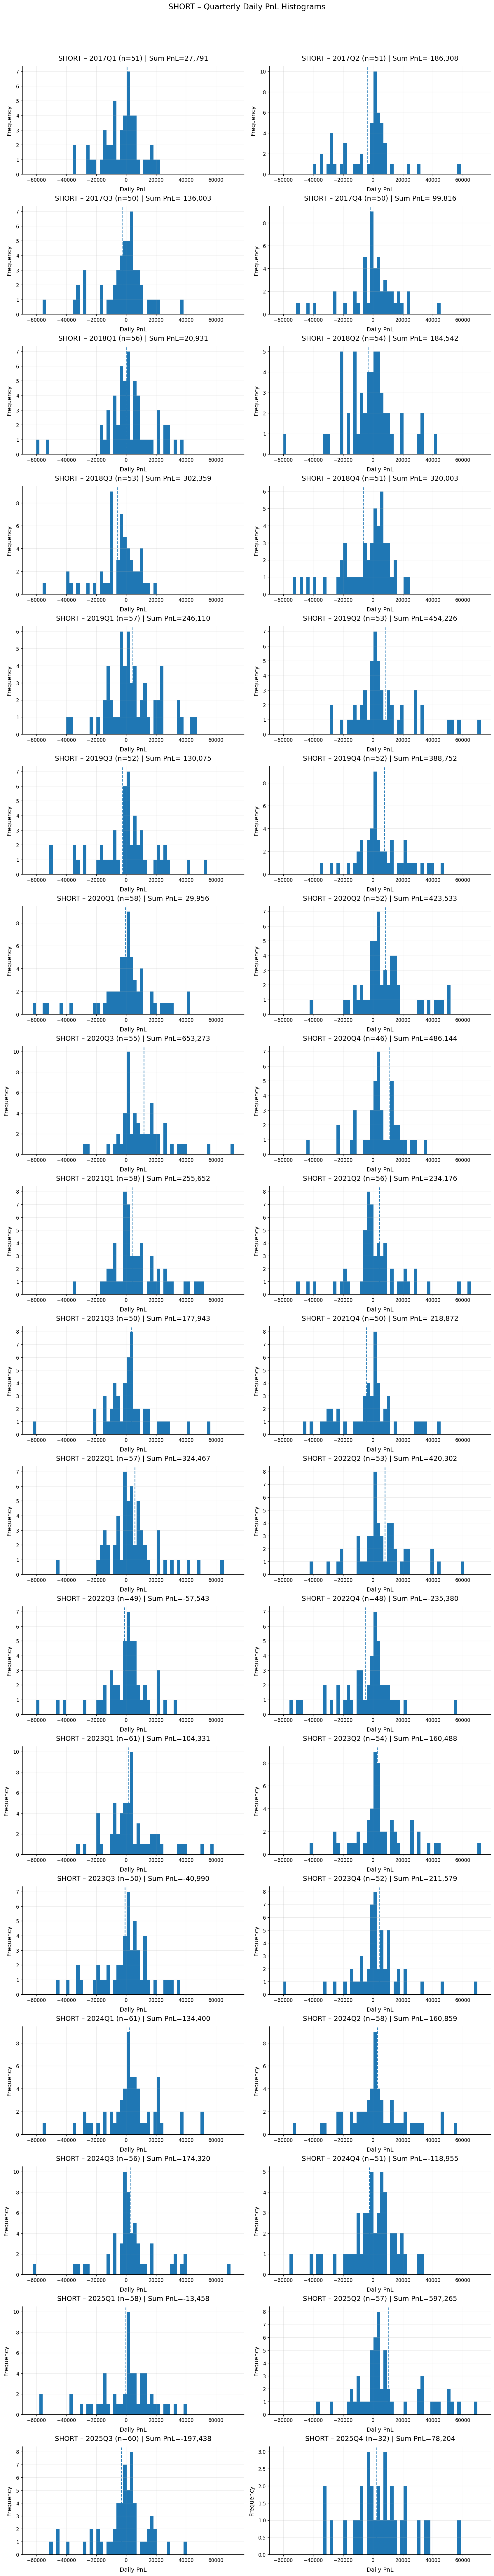

In [14]:
plot_quarterly_histograms(df_short, title_prefix="SHORT – ")

In [17]:
def sharpe_by_quarter(
    df: pl.DataFrame,
    pnl_col: str = "daily_pnl",
    quarter_col: str = "quarter",
    annualization_factor: int = 252,
) -> pl.DataFrame:
    """
    Sharpe per quarter:
      mean(daily_pnl) / std(daily_pnl) * sqrt(annualization_factor)
    Uses non-null daily_pnl; (optionally) filters zero PnL to match your preference.
    """
    out = (
        df
        .filter(pl.col(pnl_col).is_not_null())
        .filter(pl.col(pnl_col) != 0.0)
        .group_by(quarter_col)
        .agg([
            pl.len().alias("n_days"),
            pl.col(pnl_col).mean().alias("mean_daily_pnl"),
            pl.col(pnl_col).std().alias("std_daily_pnl"),
            pl.col(pnl_col).sum().alias("sum_pnl"),
        ])
        .with_columns(
            pl.when(pl.col("std_daily_pnl").is_not_null() & (pl.col("std_daily_pnl") > 0))
            .then((pl.col("mean_daily_pnl") / pl.col("std_daily_pnl")) * pl.lit(np.sqrt(annualization_factor)))
            .otherwise(pl.lit(0.0))
            .alias("sharpe_ann")
        )
        .sort(quarter_col)
    )
    return out


In [21]:
sh_long  = sharpe_by_quarter(df_long).with_columns(pl.lit("long").alias("strategy"))
sh_short = sharpe_by_quarter(df_short).with_columns(pl.lit("short").alias("strategy"))

sh_all = pl.concat([sh_long, sh_short]).sort(["quarter", "strategy"])
sh_all

quarter,n_days,mean_daily_pnl,std_daily_pnl,sum_pnl,sharpe_ann,strategy
str,u32,f32,f32,f32,f32,str
"""2017Q1""",50,-5002.471191,14668.075195,-250123.5625,-5.413919,"""long"""
"""2017Q1""",51,544.923767,23419.767578,27791.113281,0.369363,"""short"""
"""2017Q2""",47,971.514648,10410.450195,45661.1875,1.481427,"""long"""
"""2017Q2""",51,-3653.103027,17295.492188,-186308.25,-3.352967,"""short"""
"""2017Q3""",52,1160.004883,4900.618164,60320.253906,3.757588,"""long"""
"""2017Q3""",50,-2720.05835,16049.993164,-136002.921875,-2.690318,"""short"""
"""2017Q4""",47,3475.892578,7211.408203,163366.953125,7.651499,"""long"""
"""2017Q4""",50,-1996.324341,21418.353516,-99816.21875,-1.479603,"""short"""
"""2018Q1""",55,2857.438721,11817.741211,157159.125,3.838334,"""long"""


In [31]:
def plot_vix_decile_sharpe(
    df_long: pl.DataFrame,
    df_short: pl.DataFrame,
    vix_col: str = "VIX",
    pnl_col: str = "daily_pnl",
    annualization_factor: int = 252,
):
    # Compute tables
    sh_long = vix_decile_sharpe(
        df_long, "Long",
        vix_col=vix_col,
        pnl_col=pnl_col,
        annualization_factor=annualization_factor,
    )
    sh_short = vix_decile_sharpe(
        df_short, "Short",
        vix_col=vix_col,
        pnl_col=pnl_col,
        annualization_factor=annualization_factor,
    )

    combined = pl.concat([sh_long, sh_short])

    # Convert to pandas for plotting
    pdf = combined.to_pandas()

    # Build x-axis labels from VIX ranges (shared across strategies)
    vix_ranges = (
        pdf
        .drop_duplicates(subset=["decile"])
        .sort_values("decile")
        .apply(
            lambda r: f"{r['vix_min']:.1f}–{r['vix_max']:.1f}",
            axis=1,
        )
        .tolist()
    )

    deciles = sorted(pdf["decile"].unique())
    x = np.arange(len(deciles))

    fig, ax = plt.subplots(figsize=(14, 6))

    for strat in ["Long", "Short"]:
        sub = (
            pdf[pdf["strategy"] == strat]
            .sort_values("decile")
        )
        ax.plot(
            x,
            sub["sharpe_ann"].values,
            marker="o",
            linewidth=2,
            label=strat,
        )

    ax.set_title("Annualized Sharpe by VIX Decile (Full Sample)")
    ax.set_xlabel("VIX Range (by decile)")
    ax.set_ylabel("Annualized Sharpe (Mean/Std × √252)")
    ax.axhline(0.0, linewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels(vix_ranges, rotation=45, ha="right")

    ax.legend()
    plt.tight_layout()
    plt.show()

    return combined


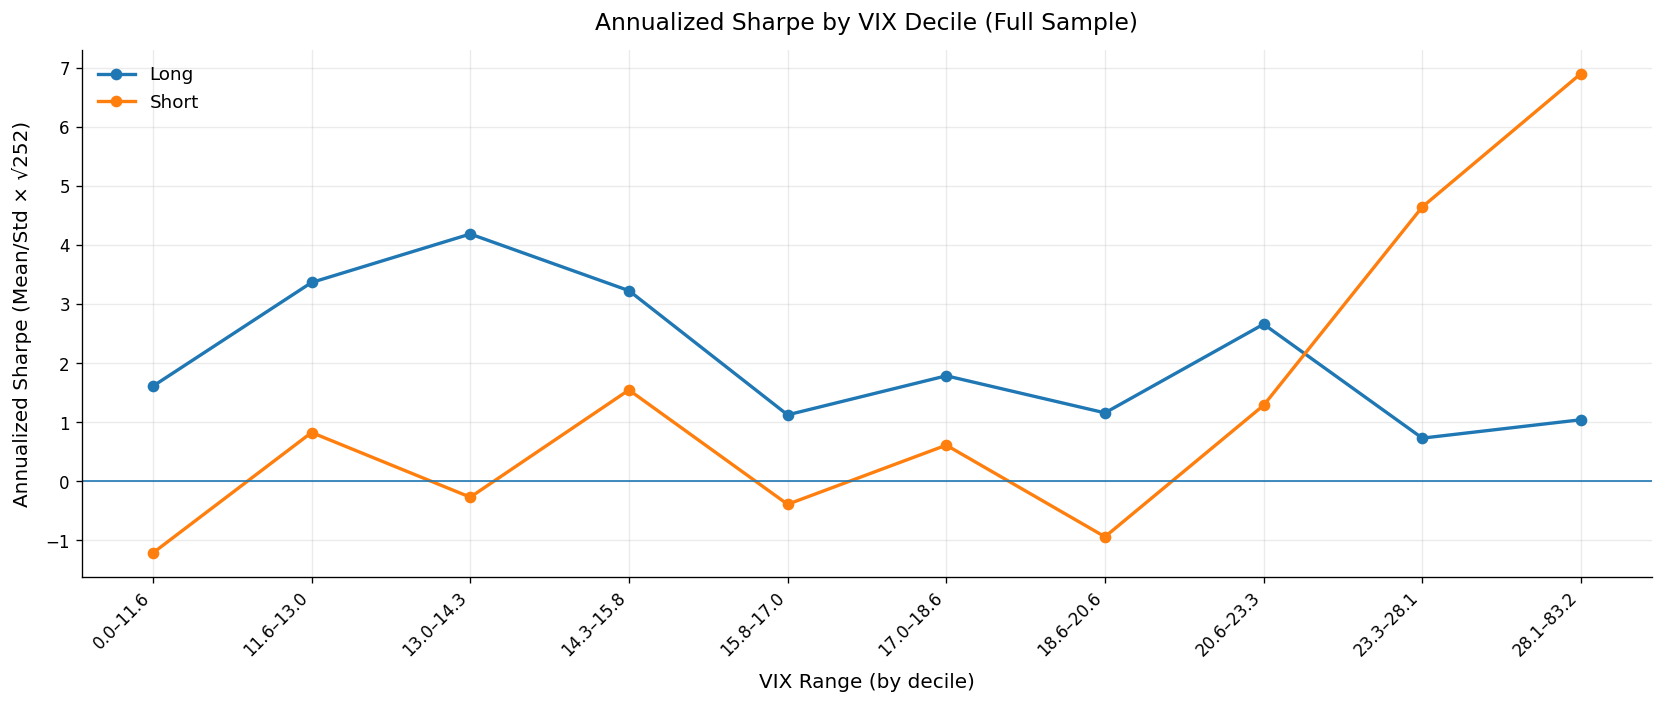

strategy,decile,n_days,vix_min,vix_max,vix_mean,sum_pnl,mean_pnl,std_pnl,sharpe_ann
str,i64,u32,f32,f32,f32,f32,f32,f32,f32
"""Long""",1,185,0.0,11.56,8.874594,211990.546875,1145.894897,11296.62793,1.610261
"""Long""",2,182,11.57,12.958,12.364288,365087.6875,2005.976318,9462.795898,3.365167
"""Long""",3,183,12.964,14.294,13.581495,645407.75,3526.818359,13377.22168,4.185212
"""Long""",4,183,14.299,15.786,15.045774,796679.3125,4353.438965,21417.638672,3.226719
"""Long""",5,184,15.795,16.999001,16.378836,178088.859375,967.874207,13654.892578,1.125203
"""Long""",6,183,17.000999,18.622,17.77466,397790.15625,2173.716797,19319.894531,1.78607
"""Long""",7,183,18.639999,20.610001,19.606911,234414.0625,1280.951172,17544.720703,1.159008
"""Long""",8,183,20.617001,23.318001,21.914736,545596.375,2981.400879,17796.011719,2.659487
"""Long""",9,183,23.32,28.087,25.653889,206559.4375,1128.740112,24499.388672,0.731373


In [32]:
decile_stats = plot_vix_decile_sharpe(df_long, df_short)
decile_stats
